In [17]:
import joblib, os, time
import onnxruntime as ort
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from utils.Dataset import CraneDataset
from tqdm.notebook import tqdm

In [2]:
est_model = joblib.load('rf_model.joblib')
est_model

RandomForestRegressor(max_features='log2', n_estimators=50, n_jobs=48,
                      random_state=0)

In [3]:
initial_type = [('float_input', FloatTensorType([None, est_model.n_features_in_]))]

onnx_model = convert_sklearn(est_model, initial_types=initial_type)

onnx_model.graph.output[0].type.tensor_type.shape.dim[1].dim_value = 10

In [4]:
for input_layer in onnx_model.graph.input:
    input_name = input_layer.name  # 입력 이름
    input_shape = [dim.dim_value for dim in input_layer.type.tensor_type.shape.dim]  # 입력 형태
    
    print(f"Input name: {input_name}")
    print(f"Input shape: {input_shape}")

Input name: float_input
Input shape: [0, 15]


In [5]:
for output in onnx_model.graph.output:
    print(f"Output name: {output.name}")
    print(f"Output shape: {[d.dim_value for d in output.type.tensor_type.shape.dim]}")

Output name: variable
Output shape: [0, 10]


In [6]:
onnx_model_path = "rf_model.onnx"

with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

In [10]:
data_file_path_list = []
data_file_name_list = os.listdir('data')

for file_name in data_file_name_list:
    data_file_path_list.append(os.path.join('data', file_name))

dataset_inst = CraneDataset(data_file_path_list)
raw_dataset = dataset_inst.get_dataset()

feature_names = dataset_inst.get_data_feature_names()
target_names = dataset_inst.get_data_target_names()

for t_name in target_names:
    raw_dataset[t_name] = raw_dataset[t_name]/1000

for t_name in target_names:
    raw_dataset = raw_dataset[raw_dataset[t_name]>=1]

#raw_dataset = raw_dataset[raw_dataset['Time(sec)']>0]

raw_dataset.reset_index(drop=True, inplace=True)

extra_feature_name_list = ['boom+roll/load', 'boom+pitch/load', 'swing/load', 'roll/pitch', 'load/roll', 'load/pitch', 'boom+roll', 'boom+pitch', 'boom_x_pos', 'boom_y_pos']

raw_dataset['boom+roll/load'] = (raw_dataset['Boom_Angle(deg)']+raw_dataset['Roll_Angle(deg)'])/raw_dataset['Load(Ton)']
raw_dataset['boom+pitch/load'] = (raw_dataset['Boom_Angle(deg)']+raw_dataset['Pitch_Angle(deg)'])/raw_dataset['Load(Ton)']
raw_dataset['swing/load'] = raw_dataset['Swing_Angle(deg)']/raw_dataset['Load(Ton)']
raw_dataset['roll/pitch'] = raw_dataset['Roll_Angle(deg)']/raw_dataset['Pitch_Angle(deg)']
raw_dataset['load/roll'] = raw_dataset['Load(Ton)']/raw_dataset['Roll_Angle(deg)']
raw_dataset['load/pitch'] = raw_dataset['Load(Ton)']/raw_dataset['Pitch_Angle(deg)']
raw_dataset['boom+roll'] = raw_dataset['Boom_Angle(deg)'] + raw_dataset['Roll_Angle(deg)']
raw_dataset['boom+pitch'] = raw_dataset['Boom_Angle(deg)'] + raw_dataset['Pitch_Angle(deg)']
raw_dataset['boom_x_pos'] = np.cos(np.deg2rad(raw_dataset['Swing_Angle(deg)'])) * np.cos(np.deg2rad(raw_dataset['Boom_Angle(deg)']))
raw_dataset['boom_y_pos'] = np.sin(np.deg2rad(raw_dataset['Swing_Angle(deg)'])) * np.cos(np.deg2rad(raw_dataset['Boom_Angle(deg)']))

diff_boom_angle = np.diff(raw_dataset['Boom_Angle(deg)'])
diff_swing_angle = np.diff(raw_dataset['Swing_Angle(deg)'])
diff_roll_angle = np.diff(raw_dataset['Roll_Angle(deg)'])
diff_pitch_angle = np.diff(raw_dataset['Pitch_Angle(deg)'])

#extra_feature_name_list = ['grad_boom_angle', 'grad_swing_angle', 'grad_roll_angle', 'grad_pitch_angle']
#new_feature_names = feature_names + extra_feature_name_list

#for extra_feature_name, extra_feature  in zip(extra_feature_name_list, [grad_boom_angle, grad_swing_angle, grad_roll_angle, grad_pitch_angle]):
#    raw_dataset[extra_feature_name] = extra_feature

train_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 0]
train_dataset = train_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
train_dataset = train_dataset[feature_names[0:4]+[feature_names[5]]+extra_feature_name_list+target_names]
train_dataset.reset_index(drop=True, inplace=True)

val_dataset_1 = raw_dataset[raw_dataset['dataset_type'] == 1]
val_dataset = val_dataset_1.drop(columns=['Time(sec)', 'file_idx', 'safe_state', 'dataset_type'])
val_dataset = val_dataset[feature_names[0:4]+[feature_names[5]]+extra_feature_name_list+target_names]
val_dataset.reset_index(drop=True, inplace=True)

total_dataset = pd.concat([train_dataset, val_dataset])

  0%|          | 0/22 [00:00<?, ?it/s]

In [11]:
model = ort.InferenceSession('rf_model.onnx')

In [22]:
t0 = time.time()
dt_time_list = []
target_start_idx = 15


for i in tqdm(range(total_dataset.shape[0])):
    t1 = time.time()
    pred = model.run(output_names=None, input_feed={'float_input': total_dataset.iloc[i, 0:target_start_idx].to_numpy(np.float32).reshape(1, -1)})[0][0]
    if i == 0:
        print(t1-t0)
    dt_time_list.append(1/(time.time() - t1 + 0.00001))

  0%|          | 0/93251 [00:00<?, ?it/s]

0.007999897003173828


Text(0, 0.5, 'Execution Period(Hz)')

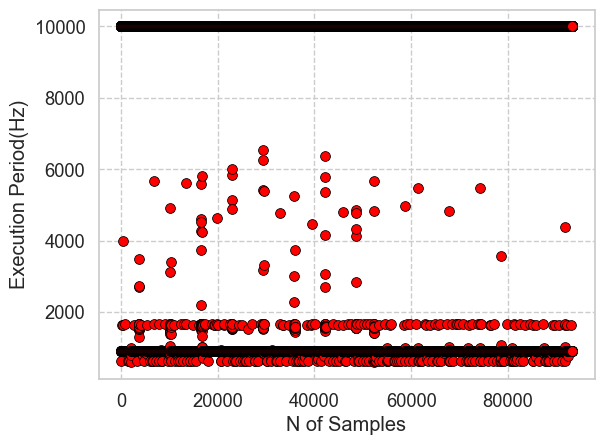

In [23]:
sns.set_theme(font_scale=1.2)
sns.set_style("whitegrid", {'grid.linestyle': '--'})

sns.scatterplot(x=np.arange(0, len(dt_time_list), 1), y=dt_time_list, edgecolor='black', color='red', s=50)

plt.xlabel('N of Samples')
plt.ylabel('Execution Period(Hz)')